In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

### Trying to plot a random set of arrows in matplotlib

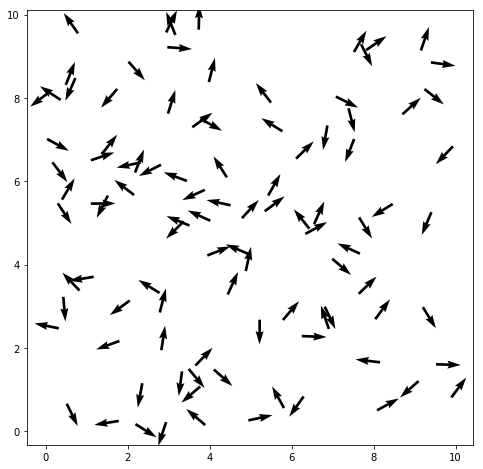

In [2]:
dx = 1
dy = 1
L = 10

plt.figure(figsize=(8,8))
x, y, dx, dy = np.zeros(100), np.zeros(100), np.zeros(100), np.zeros(100)
for i in range(100):
    x[i], y[i] = 10*rnd.random(), 10*rnd.random()
    dx[i], dy[i] = 2*(rnd.random()-0.5), 2*(rnd.random()-0.5)
    dr = np.sqrt(dx[i]**2 + dy[i]**2)
    dx[i] *= 1/dr
    dy[i] *= 1/dr
plt.quiver(x,y, dx, dy)
plt.show()

---

In [3]:
class Configuration(object):
    def __init__(self, L, N, eta, dt): #, v, r):
        self.size = L
        self.N = N
        self.x, self.y = np.zeros(N), np.zeros(N) 
        self.v = 1
        self.theta = np.zeros(N)
        for i in range(N):
            self.x[i], self.y[i] = L*rnd.random(), L*rnd.random()
            self.theta[i] = 2*np.pi*rnd.random()
        self.eta = eta
        self.dt = dt
        self.r = 0.3  # radius within which the particles interact with each other
        
    def get_avg_speed(self):
        avg_speed = np.array([0.0, 0.0])
        for i in range(self.N):
            avg_speed += np.array([np.cos(self.theta[i]), np.sin(self.theta[i])])
        return np.sqrt(avg_speed[0]**2 + avg_speed[1]**2)/self.N
    
    def get_energy(self):
        # ...
        return e
    
    def get_magnetization(self):
        # ...
        return m

### Metropolis move

In [4]:
def move(config):
    """Modify (or not) a configuration with Metropolis algorithm"""

    L = config.size
    N = config.N
    r = config.r
    v = config.v
    dt = config.dt
    eta = config.eta

    for i in range(N):
        config.x[i] = (config.x[i] + v * np.cos(config.theta[i]) * dt) % L  # update position of particle i
        config.y[i] = (config.y[i] + v * np.sin(config.theta[i]) * dt) % L  # update position of particle i
        lst_close = []
        for j in range(N):
            distance = np.sqrt((config.x[j] - config.x[i]) ** 2 + (config.y[j] - config.y[i]) ** 2)
            if distance < r:
                lst_close.append(j)
        median_theta = 0
        for k in range(len(lst_close)):
            median_theta += config.theta[lst_close[k]]
        median_theta = median_theta / len(lst_close)
        delta_theta = eta * rnd.random()
        config.theta[i] = median_theta + delta_theta


#### Plot

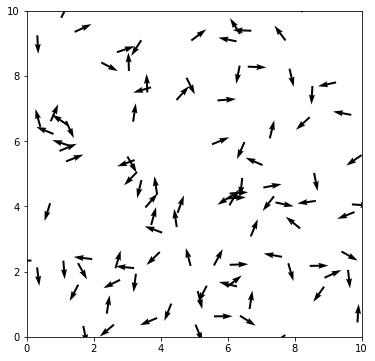

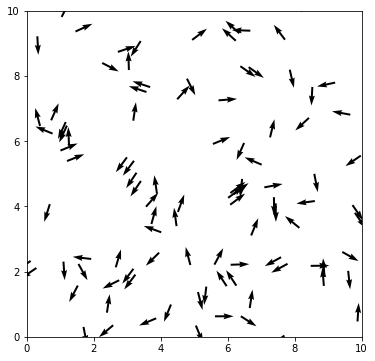

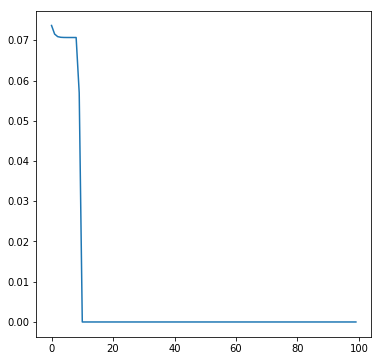

In [6]:
L = 10
N = 100
eta = 0.00
dt = 0.003

config = Configuration(L, N, eta, dt)

plt.figure(figsize=(6, 6))
plt.quiver(config.x, config.y, np.cos(config.theta), np.sin(config.theta))
plt.xlim(0, L)
plt.ylim(0, L)

avg_speed = np.zeros(100)
for i in range(10):
    move(config)
    avg_speed[i] = config.get_avg_speed()
    # plt.figure(figsize=(6,6))
    # plt.quiver(config.x,config.y, np.cos(config.theta), np.sin(config.theta))

plt.figure(figsize=(6, 6))
plt.quiver(config.x, config.y, np.cos(config.theta), np.sin(config.theta))
plt.xlim(0, L)
plt.ylim(0, L)

plt.figure(figsize=(6, 6))
plt.plot([i for i in range(100)], avg_speed)

plt.show()


### Animation

In [7]:
import matplotlib.animation as animation

In [8]:
% matplotlib notebook

L = 10
N = 100
eta = 0.02 * np.pi
dt = 0.03

config = Configuration(L, N, eta, dt)

X, Y = config.x, config.y
U = np.cos(config.theta)
V = np.sin(config.theta)

Writer = animation.writers['ffmpeg']  # to save video
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=18000)  # to save video

fig, ax = plt.subplots(1, 1)
Q = ax.quiver(X, Y, U, V)

ax.set_xlim(0, L)
ax.set_ylim(0, L)


def update_quiver(num, Q, X, Y):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """
    move(config)

    X, Y = config.x, config.y
    new_offsets = np.zeros((config.N, 2))
    for i in range(N):
        new_offsets[i][0] = X[i]
        new_offsets[i][1] = Y[i]
    U = np.cos(config.theta)
    V = np.sin(config.theta)
    Q.set_offsets(new_offsets)
    Q.set_UVC(U, V)

    return Q,



anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, X, Y),
                               interval=200, blit=False)
anim.save('lines.mp4', writer=writer)
fig.tight_layout()
plt.show()


<IPython.core.display.Javascript object>

<div id='105b6470-a6e7-4923-bcf6-a15da2a7ac0e'></div>